In [1]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
import pandas as pd

%load_ext autoreload
%autoreload 2
import pre_ml
import mlpipeline

In [2]:
covid = pre_ml.data()

print(covid.shape)
covid.head(5)

Requesting data to datos abiertos Mexico
Getting zip raw data into directory, will delete soon
Raw data deleted. If you specified filename, clean data will be saved in data directory
(93435, 21)


,entidad_res,municipio_res,CVE_MUN,embarazo,edad,diabetes,epoc,asma,inmusupr,hipertension,...,obesidad,tabaquismo,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras,hospitalizado,muertos,covid_grave
0,25,6,25006,0.0,27,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.2,152.715706,2.637944,10.489463,30.502528,0,0,0
1,27,4,27004,0.0,44,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,36.3,430.537057,5.448810,13.926240,41.575909,0,0,0
2,27,5,27005,0.0,52,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,63.6,283.191451,3.401376,2.436121,8.319582,1,0,1
3,15,58,15058,0.0,55,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,37.4,17954.252292,0.810012,2.870259,10.248409,0,0,0
4,2,4,2004,0.0,47,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,31.1,1449.318075,0.726447,4.889549,11.701390,1,1,1


In [3]:
print('hospitalizado')
print(covid['hospitalizado'].value_counts())
print('muerto')
print(covid['muertos'].value_counts())
print('covid grave')
print(covid['covid_grave'].value_counts())

hospitalizado
0    60828
1    32607
Name: hospitalizado, dtype: int64
muerto
0    83268
1    10167
Name: muertos, dtype: int64
covid grave
0    59785
1    33650
Name: covid_grave, dtype: int64


# Predicting Deaths 
(using SMOTE)

The correct application of oversampling during k-fold cross-validation is to apply the method to the training dataset only, then evaluate the model on the stratified but non-transformed test set.

The ideal way to conduct this experiment is to perform oversampling of the training set in each cross-validation iteration, not before beginning the process. This prevents the data leakage from the validation set to the training set during cross-validation, and reflects how the model trained on a balanced training set would perform when applied to an imbalanced, unseen test set.

* In each iteration exclude some data for validation. The excluded data should not be used for feature selection, oversampling and model building.
* Oversample the minority class only in the training set without the data already excluded for validation.
* Repeat K times, where K is number of folds.

This can be achieved by defining a Pipeline that first transforms the training dataset with SMOTE then fits the model.
This pipeline can then be evaluated using repeated k-fold cross-validation.

In [5]:
#separate training and testing
train, test = mlpipeline.split_data(covid, 0.2, 1)
print(train.shape)

#normalize train and test continous variables
train, test = mlpipeline.normalize(train, test, ['edad', 'pobreza', 'Densidad_pob', 'medicos',
                                                            'camas_hosp', 'enfermeras'])
train[['edad', 'pobreza', 'Densidad_pob', 'medicos','camas_hosp', 'enfermeras']].describe().loc[['mean', 'std'], :]

(74748, 21)


,edad,pobreza,Densidad_pob,medicos,camas_hosp,enfermeras
mean,6.787172e-17,-2.310870e-16,3.659749e-18,1.141652e-16,5.893623e-18,-1.978641e-16
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00


In [8]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['muertos']

MODELS = {'LogisticRegression': LogisticRegression()}

GRID = {'LogisticRegression': [{'penalty': x, 'C': y, 'random_state': 0, 'solver':'lbfgs'} 
                           for x in ('l2',) \
                           for y in (0.01, 0.1, 1, 10, 100)]}

results, best_model = mlpipeline.grid_search(train, features, target, MODELS, GRID)

print(best_model)
print(best_model.coef_)
results

Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.01, 'random_state': 0, 'solver': 'lbfgs'}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.1, 'random_state': 0, 'solver': 'lbfgs'}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 1, 'random_state': 0, 'solver': 'lbfgs'}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 10, 'random_state': 0, 'solver': 'lbfgs'}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 100, 'random_state': 0, 'solver': 'lbfgs'}


In [32]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['muertos']

pipeline = make_pipeline((SMOTE(random_state=0)), LogisticRegression(random_state=0))

kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#model
params = {'logisticregression__penalty': ['l2'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100],
          'logisticregression__solver': ['lbfgs']}

grid_d = GridSearchCV(estimator=pipeline,
                    param_grid=params,
                    cv=kf,
                    return_train_score=True,
                    scoring= ['accuracy', 'precision', 'recall'],
                    refit = 'recall',
                    iid = True)

grid_d.fit(train[features].values, train[target].values.ravel())
results = pd.DataFrame(grid_d.cv_results_)
results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.718971,0.238812,0.727230
1,"{'logisticregression__C': 0.1, 'logisticregres...",0.719096,0.238878,0.727066
2,"{'logisticregression__C': 1, 'logisticregressi...",0.719110,0.238922,0.727271
3,"{'logisticregression__C': 10, 'logisticregress...",0.719118,0.238929,0.727271
4,"{'logisticregression__C': 100, 'logisticregres...",0.719118,0.238929,0.727271


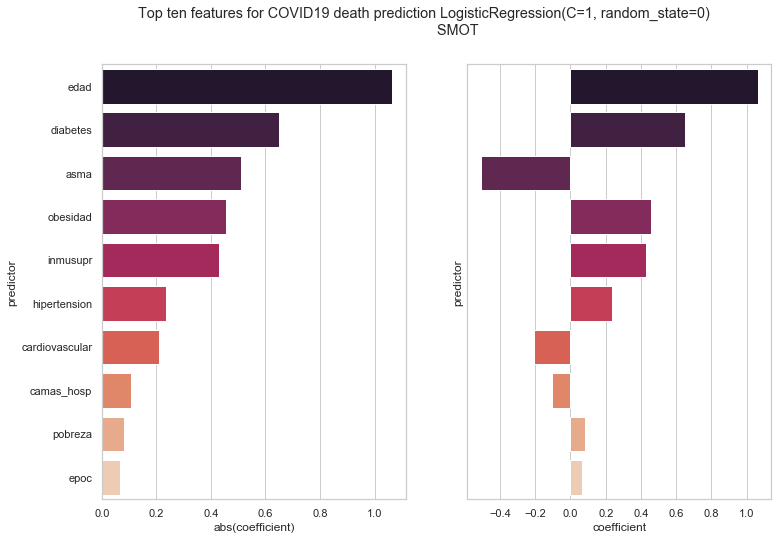

In [33]:
import seaborn as sns

best_model = grid_d.best_estimator_.get_params()['steps'][1][1]

coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':best_model.coef_.flatten(),
                                 'abs_coeffient':abs(best_model.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 death prediction {} 
                SMOT'''.format(best_model))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

[[11931  4696]
 [  584  1476]]


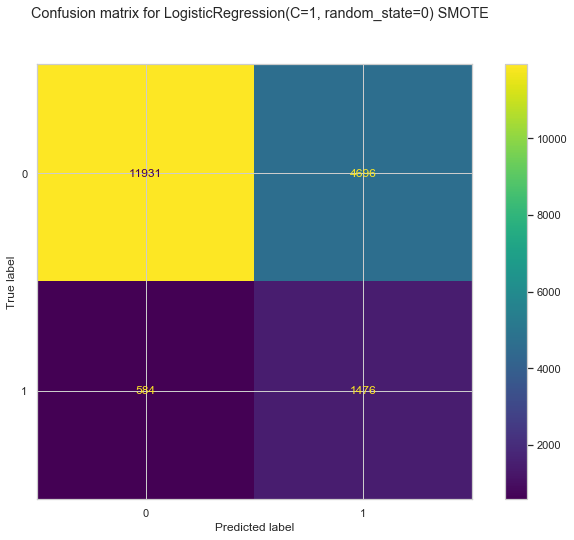

In [40]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

pred = best_model.predict(test[features])

cm = confusion_matrix(test[target],pred)
print(cm)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(best_model)+ ' SMOTE');
plot_confusion_matrix(best_model, test[features], test[target], ax=ax);

In [41]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(accuracy_score(test[target],pred),
                       precision_score(test[target],pred), 
                       recall_score(test[target],pred),
                       f1_score(test[target],pred)))

Accuracy: 0.7174506341306791
Precision: 0.2391445236552171
Recall: 0.7165048543689321
F1 Score: 0.358600583090379


# Predicting Hospitalization

In [44]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['hospitalizado']

pipeline = make_pipeline((SMOTE(random_state=0)), LogisticRegression(random_state=0))

kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#model
params = {'logisticregression__penalty': ['l2'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100],
          'logisticregression__solver': ['lbfgs']}

grid_h = GridSearchCV(estimator=pipeline,
                    param_grid=params,
                    cv=kf,
                    return_train_score=True,
                    scoring= ['accuracy', 'precision', 'recall'],
                    refit = 'recall',
                    iid = True)

grid_h.fit(train[features].values, train[target].values.ravel())
results = pd.DataFrame(grid_h.cv_results_)
results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.704393,0.564161,0.674738
1,"{'logisticregression__C': 0.1, 'logisticregres...",0.704327,0.564148,0.673997
2,"{'logisticregression__C': 1, 'logisticregressi...",0.704407,0.564256,0.673985
3,"{'logisticregression__C': 10, 'logisticregress...",0.704429,0.564282,0.674023
4,"{'logisticregression__C': 100, 'logisticregres...",0.704429,0.564283,0.674010


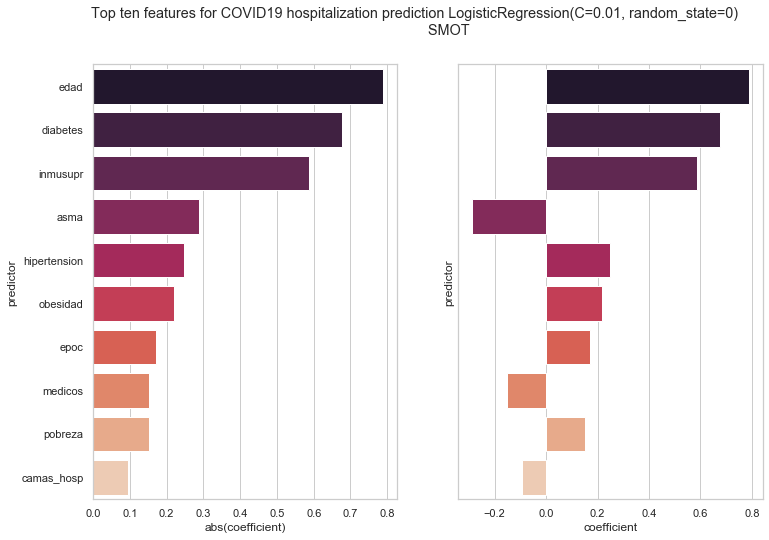

In [45]:
best_model = grid_h.best_estimator_.get_params()['steps'][1][1]

coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':best_model.coef_.flatten(),
                                 'abs_coeffient':abs(best_model.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 hospitalization prediction {} 
                SMOT'''.format(best_model))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

[[8732 3448]
 [2135 4372]]


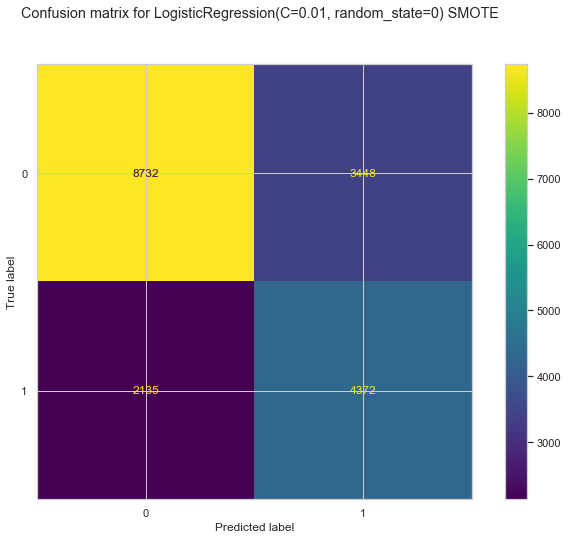

In [46]:
pred = best_model.predict(test[features])

cm = confusion_matrix(test[target],pred)
print(cm)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(best_model)+ ' SMOTE');
plot_confusion_matrix(best_model, test[features], test[target], ax=ax);

In [47]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(accuracy_score(test[target],pred),
                       precision_score(test[target],pred), 
                       recall_score(test[target],pred),
                       f1_score(test[target],pred)))

Accuracy: 0.7012361534756782
Precision: 0.5590792838874681
Recall: 0.6718918088212694
F1 Score: 0.610316186221819


# Predicting Hospitalization/Death

In [49]:
features = ['edad', 'diabetes', 'epoc', 'asma', 'inmusupr', 'hipertension', 'cardiovascular',
            'obesidad', 'tabaquismo', 'pobreza', 'medicos', 'camas_hosp', 'enfermeras']
target= ['covid_grave']

pipeline = make_pipeline((SMOTE(random_state=0)), LogisticRegression(random_state=0))

kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#model
params = {'logisticregression__penalty': ['l2'],
          'logisticregression__C': [0.01, 0.1, 1, 10, 100],
          'logisticregression__solver': ['lbfgs']}

grid_hm = GridSearchCV(estimator=pipeline,
                    param_grid=params,
                    cv=kf,
                    return_train_score=True,
                    scoring= ['accuracy', 'precision', 'recall'],
                    refit = 'recall',
                    iid = True)

grid_hm.fit(train[features].values, train[target].values.ravel())
log_results = pd.DataFrame(grid_hm.cv_results_)
log_results[['params', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall']]

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


,params,mean_test_accuracy,mean_test_precision,mean_test_recall
0,"{'logisticregression__C': 0.01, 'logisticregre...",0.710298,0.583976,0.680213
1,"{'logisticregression__C': 0.1, 'logisticregres...",0.710217,0.583968,0.679507
2,"{'logisticregression__C': 1, 'logisticregressi...",0.710200,0.583967,0.679346
3,"{'logisticregression__C': 10, 'logisticregress...",0.710195,0.583964,0.679322
4,"{'logisticregression__C': 100, 'logisticregres...",0.710200,0.583967,0.679346


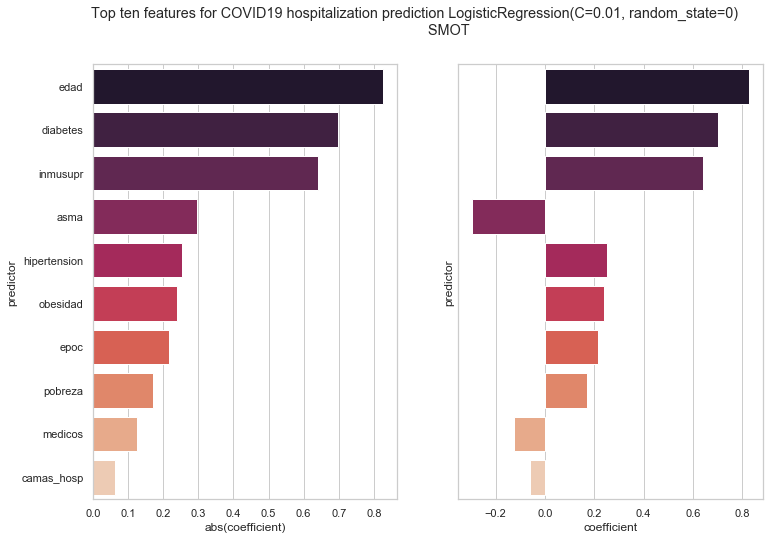

In [50]:
best_model = grid_hm.best_estimator_.get_params()['steps'][1][1]

coeffs = pd.DataFrame.from_dict({'predictor':features,
                                 'coefficient':best_model.coef_.flatten(),
                                 'abs_coeffient':abs(best_model.coef_.flatten())})
coeffs.sort_values(by='abs_coeffient', inplace=True,ascending=False)

sns.set(style="whitegrid") 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 8)
plt.suptitle('''Top ten features for COVID19 hospitalization prediction {} 
                SMOT'''.format(best_model))

plt.sca(ax[0])
sns.barplot(x="abs_coeffient", y="predictor", data=coeffs[0:10],
            palette="rocket")
ax[0].set_xlabel('abs(coefficient)')

plt.sca(ax[1])
sns.barplot(x="coefficient", y="predictor", data=coeffs[0:10],
            palette="rocket")
plt.setp(ax[1],yticks=[]);

[[8648 3309]
 [2179 4551]]


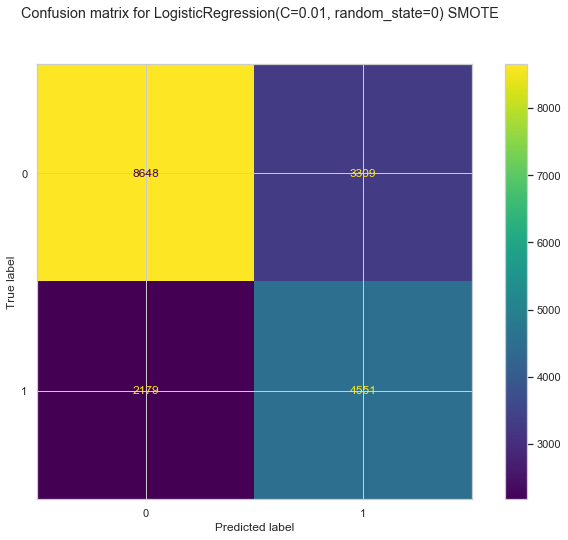

In [51]:
pred = best_model.predict(test[features])

cm = confusion_matrix(test[target],pred)
print(cm)

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
plt.suptitle('Confusion matrix for '+str(best_model)+ ' SMOTE');
plot_confusion_matrix(best_model, test[features], test[target], ax=ax);

In [52]:
print('''Accuracy: {}
Precision: {}
Recall: {}
F1 Score: {}'''.format(accuracy_score(test[target],pred),
                       precision_score(test[target],pred), 
                       recall_score(test[target],pred),
                       f1_score(test[target],pred)))

Accuracy: 0.706319901535827
Precision: 0.5790076335877863
Recall: 0.6762258543833581
F1 Score: 0.6238519533927348
